In [2]:
# Import dependencies

# Flatiron school cohort package
from fsds_100719.imports import *

# nltk
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Preprocessing
import re
import string
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy.sparse import vstack
import pandas as pd
import numpy as np
import os

# Modeling
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dougl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\externals\six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

Using TensorFlow backend.


In [3]:
def multi_class_SMOTE(X, y, n, random_state, verbose=1):
    """Using imblearn.over_sampling.SMOTE, performs (n-1) iterations of SMOTE to facilitate creating balanced target classes when multiple classes are present.

    Parameters
    ----------
    X : array-like
        Matrix containing the feature data to be sampled
    y : array-like (1-d)
        Corresponding target labels for each sample in X
    n : int
        Number of unique classes/labels in y
    random_state : int
        Value to set as the random_state for SMOTE function reproducibility
    verbose : int (1 or 2)
        If 1, prints label counts only after final SMOTE iteration
        If 2, prints label counts at each SMOTE iteration (including initial)

    Returns
    ----------
    X_resampled : array-like
        Matrix containing the resampled feature data
    y_resampled : array-like (1-d)
        Corresponding target labels for X_resampled
    """

    # Initialize a SMOTE object
    smote = SMOTE(random_state=random_state)

    # Output if verbose = 2
    if verbose == 2:
        print(f'Label counts for Original y:\n{pd.Series(y).value_counts()}')

    # Perform SMOTE n-1 times to achieve balanced target classes
    for i in range(n - 1):
        X, y = smote.fit_sample(X, y)

        # Print value counts after each step if verbose == 2
        if verbose == 2:
            print(
                f'Label counts after SMOTE # {i+1}:\n{pd.Series(y).value_counts()}')

    # Print final value counts if verbose == 1
    if verbose == 1:
        print(
            f'Label counts after SMOTE # {n-1}:\n{pd.Series(y).value_counts()}')

    X_resampled = X
    y_resampled = y

    return X_resampled, y_resampled

# Obtain

In [4]:
# Load kaggle airline sentiment dataset and only select sentiment scores with 100% confidence

kaggle_df = pd.read_csv('kaggle_airline_sentiment.csv')
kaggle_df = kaggle_df.loc[kaggle_df['airline_sentiment_confidence'] == 1]

len(kaggle_df)

10445

In [5]:
# Load raw American Airlines tweets obtained from twitter API

twitter_df = pd.read_csv('twitter_30_days_all_airlines.csv')

twitter_df.head()

id                        datetime  \
0  1234991579502243843  Tue Mar 03 23:58:32 +0000 2020   
1  1234991364468690944  Tue Mar 03 23:57:40 +0000 2020   
2  1234991343853654017  Tue Mar 03 23:57:36 +0000 2020   
3  1234991315319848961  Tue Mar 03 23:57:29 +0000 2020   
4  1234991155688792066  Tue Mar 03 23:56:51 +0000 2020   

                                                text  retweets  
0  Just announced: @united says for flights booke...         1  
1  Does @Alitalia really stands on its position o...         2  
2  Hey @Delta I need to track down a past flight ...         0  
3  Hey @Delta now we’re stuck because you cancele...         0  
4  OMG! I’m flying @americanair. All I can think ...         0

# Scrub

In [6]:
# Identify stop words
stopwords_list = stopwords.words('english')
punc_list = list(string.punctuation)
stopwords_list += punc_list
str_ell_list = ["''", '""', '...', '``']
stopwords_list += str_ell_list

## Function to clean tweets

In [7]:
def clean_tweet(tweet):
    
    # Remove punctuation
    tweet = tweet.translate(string.punctuation)
    tweet = tweet.lower().split()
    
#     stemmer = SnowballStemmer("english")
#     tweet = [stemmer.stem(word) for word in tweet]
    # Remove stop words
#     tweet = [word for word in tweet if word not in stopwords_list]
    tweet = " ".join(tweet)
#   
    # Regular expressions
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", tweet)
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r";", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", "", tweet)
    tweet = re.sub(r":", "", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ", tweet)
    tweet = re.sub(r"\+", "plus", tweet)
    tweet = re.sub(r"\-", "minus", tweet)
    tweet = re.sub(r"\=", "equals", tweet)
    tweet = re.sub(r"'", "", tweet)
    
    return tweet

## Clean tweet text

In [8]:
# Clean tweets in kaggle dataset
kaggle_df['clean_text'] = kaggle_df['text'].map(lambda x: clean_tweet(x))    

kaggle_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                           1.0   
3  570301031407624196          negative                           1.0   
4  570300817074462722          negative                           1.0   
5  570300767074181121          negative                           1.0   
9  570295459631263746          positive                           1.0   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   
5     Can't Tell                     0.6842  Virgin America   
9            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   
5                    NaN    jnardino                 NaN              0   
9                    NaN  YupitsTate                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   
5  @VirginAmerica seriously would pay $30 a fligh...         NaN   
9  @VirginAmerica it was amazing, and arrived an ...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   
5  2015-02-24 11:14:33 -0800            NaN  Pacific Time (US & Canada)   
9  2015-02-24 10:53:27 -0800    Los Angeles  Eastern Time (US & Canada)   

                                          clean_text  
0                 virginamerica what  dhepburn said   
3   virginamerica its really aggressive to blast ...  
4   virginamerica and its a really big bad thing ...  
5   virginamerica seriously would pay  30 a fligh...  
9   virginamerica it was amazing  and arrived an ...

In [9]:
# Clean tweets in twitter dataset

twitter_df['clean_text'] = None
for i in twitter_df.index:
    twitter_df['clean_text'][i] = clean_tweet(twitter_df['text'][i])
    
twitter_df.head()

id                        datetime  \
0  1234991579502243843  Tue Mar 03 23:58:32 +0000 2020   
1  1234991364468690944  Tue Mar 03 23:57:40 +0000 2020   
2  1234991343853654017  Tue Mar 03 23:57:36 +0000 2020   
3  1234991315319848961  Tue Mar 03 23:57:29 +0000 2020   
4  1234991155688792066  Tue Mar 03 23:56:51 +0000 2020   

                                                text  retweets  \
0  Just announced: @united says for flights booke...         1   
1  Does @Alitalia really stands on its position o...         2   
2  Hey @Delta I need to track down a past flight ...         0   
3  Hey @Delta now we’re stuck because you cancele...         0   
4  OMG! I’m flying @americanair. All I can think ...         0   

                                          clean_text  
0  just announced  united says for flights booked...  
1  does  alitalia really stands on its position o...  
2  hey  delta i need to track down a past flight ...  
3  hey  delta now we re stuck because you cancele...  
4  omg i m flying  americanair  all i can think a...

In [10]:
# Test of kaggle dataset cleaned text

for i in kaggle_df['clean_text']:
    print(i)

 virginamerica what  dhepburn said 
 virginamerica its really aggressive to blast obnoxious  entertainment  in your guests faces  amp  they have little recourse
 virginamerica and its a really big bad thing about it
 virginamerica seriously would pay  30 a flight for seats that didnt have this playing plusits really the only bad thing about flying va
 virginamerica it was amazing  and arrived an hour early  youre too good to me 
 virginamerica i  lt 3 pretty graphics  so much better than minimal iconography  d
 virginamerica this is such a great deal already thinking about my 2nd trip to  australia  amp  i havent even gone on my 1st trip yet  p
 virginamerica thanks
 virginamerica so excited for my first cross country flight lax to mco ive heard nothing but great things about virgin america   29daystogo
 virginamerica i flew from nyc to sfo last week and couldnt fully sit in my seat due to two large gentleman on either side of me  help
i    flying  virginamerica     
 virginamerica you

 united  unitedairlines so my feedback is for your benefit  not for you to correct your atrocious customer service  good to know
 united  unitedairlines fill out form and never receive response  i expect remedy  we can travel another airline and cancelled flight as members w u 
 united 12 13ewrminuslax ua1151 my seat armrest broken discover after takeoff  flight full fa filed report  who to chat with for partial refund 
 united so you told me to go  knowing what the issue was  only for me to go there and find out that you won t fix it 
 united so  i made it all the way to the airport  and they say they won t fix the handle  i showed you this problem  and you said to go  
 united then why do you bother responding  your customer service is the worst  never using you guys again 
 united free hotel doesnt make up for such poor customer service and disregard
 united its messed up to refuse to wait 10 min after united is at fault for delay but to leave early is absolutely disgusting 
 united

 jetblue gorgeous day  hope the flight back tomorrow am is just as pleasant thanks
 jetblue they say they have no update  i dont work i dont get paid  jet blue has my money but no flight  argh
 jetblue well im glad i got up at 5 am so i can sit in an airport  no place else id rather be  not 
 jetblue why 730 and not 645 as scheduled 
 jetblue  1408 iad to jfk still hasnt boarded  whats todays excuse and how am i gonna get to work 
 jetblue why is t that every time i fly jfk even more speed doesnt work waiting for 10 min  nogood
 jetblue its always a pleasure   
 jetblue dumps amex minus nassau news live 
 jetblue   justdippin  drops a new video off the upcoming project  thetakeover  produced by yponthebeat  rt
 jetblue to end partnership with american express minus  
 jetblues ceo battles to appease passengers and wall street minus  
 jetblue change in the air for travelers  investors minus  bloombergnews 
 jetblue anywhere warm cause its freezing in nyc
 jetblue clients got zero  in 3

 americanair flights been cancelled flightled  cant get through to the desk and nothing showing online under my reservation minus what do i do 
 americanair the point of the pic if your reps struggle with the merger this much  imagine how it is for the public 
 americanair i was flying from ft lauderdale fl to seattle wa on the 02 28 2015 until the 03 03 2015 and they dont want to honor my flight 
 americanair wasnt able to get on hold  your system kept kicking me to the main menu 
 americanair seattle checkminusin  1 desk servicing full service line  2 desks servicing priority  full srvc wait 30plus minutes  customer svc fail
 americanair hey tried calling customer service and was told theres a 2 hour wait  this has been for the past 4 hours  thanks you suck
 americanair but have been yet to receive assistance from one of your agents in securing a new connection  many will now miss work tomorrow 
 americanair are flights from columbus ohio to dallas texas cancelled flighted 
 american

In [11]:
# Test of twitter dataset cleaned text

for i in twitter_df['clean_text']:
    print(i)

just announced  united says for flights booked between 3 3 and 3 31 no change fees for the next 12 months 
does  alitalia really stands on its position of not reimbursing tickets to italy  while  delta and united do 
hey  delta i need to track down a past flight receipt  i emailed ticketreceipt delta com last week and still haven t heard from them 
hey  delta now we re stuck because you canceled a flight which was already paid for and didn t even rebook your customers   
omg i m flying  americanair  all i can think about is beverly bass  the first female american captain in history   wecomefromaway nyaweh for teaching us her story  i ll be think about her all the way to  to minus and listen to your soundtrack  it s habit now  
also  my  southwestair flight from austin to st  louis was absolutely wonderful the lady who sat next to me was the other lady having to listen to drunk amys wailing  we chatted the whole way here and shes lovely  fastfriendswithvita
shout out to wendy at gate 46

thank you  spiritairlines for a fun  safe  and enjoyable flight no better way to start a vacation 
when will the major airlines like delta  united  and american offer refunds for booked flights   delta  unitedairlines  americanair  italy  italycoronavirus  covid19 
waiting for an email for over 30 minutes from  spiritairlines to reset your password because their site was compromised  is a form for mental abuse 
hey  united minus i sent that number yesterday  here it is the file ref   again dfw87767m  your team since thursday has not reunited me with my bag  it is now sunday and i am returning home without having seen it  i repeat do you care  
one more time on the way home  flyfrontier you suck no way are you accommodating for bigger people
american airlines says squeezing more seats onto planes is amazing  and what customers really want     americanair  i am here to tell you that your customers are very unhappy 
a huge shoutout to the crew of  delta dl011  lhr msp  today making my 30t

 peterdutton  auspol  lnp plusno infection transmission precautionary measures at  airports in  australia to  cause  epidemic including amongst all  airport  customs  borderforce  qantas  virginair  staff all at risk extreme  negligence plusneed  sanitiser  antiseptic cleaning protocol 
good bye chicago  thank you for the dry skin  thank you to  womaninredvhc at  virginhotelschi  sfo here we come via  alaskaair   favoritebrands
jetblue airways travel voucher certificate round trip benefit nonprofit   25 bids    jetblue  airways  travel  251 0  price   25 bids count   end time 2020minus03minus01 201857 pdt
maui s  kahului airport is hands down the worst experience i ve ever had  took us 2 hours to get thru and our flight is delayed by an hour due to 50plus passengers stuck in security line   maui  oggairport  kahuluiairport  unitedairlines
what s going on with my flight   americanair aa1761 minus keeps getting delayed with barely any explanation  help  barstoolbigcat
 wtfee demand  amer

hello  americanair  last night on your flight miaminusgye 927  a drunk passenger allegedly stole liquor from the plane s kitchen  peed in the aisle  yelled  insulted and threatened other passengers  and the crew was unable to control the situation  
just discovered my favorite new artist since  brettyoungmusic       ingridandress minus amazing singer songwriter and thanks to  applemusic plus  americanairplusthis happened at 30k feet
i don t know why i assume that  americanairlines will do the right thing because they are the worst airline of all time  speaking from past experiences 
hoping  americanairlines will come to their senses for once in their lives and waive cancellation fees for all flights to italy 
  alaskaair wants to transform you from a fan to a vip two lucky alaska mileage plan  members will  win a trip to the  iheartradio music awards in  la  iheartawards 
where can you access receipts for baggage fees  americanair
  alaskaair wants to transform you from a fan to a vip 

hope my next experience on  united is better than current one on ua 4831 where we ve waited 35 minutes since landing for a ground crew at  bufairport
love love  luv  southwestair  stevewittich  tso patrick  if i had a nickle for every indminustpaminusind 
i like  jetblue 
guess whose got another mechanical issue for a third plane in two daysplusplusyou suck  united you buncha assholes
this is why i never fly  americanair they are always delayed and have worse customer service  only reason i am even flying with them is because my job paid for the flight  i always fly  delta the customer service is better and i have never been delayed with them  ridiculous
if  spiritairlines ever offered you a future travel voucher as a compensation for a problem you had flying this airline  just say no    they are worthless  spirit when did u stop caring about your customers 
strangers on a plane throw impromptu baby shower for couple flying home with newly adopted infant   this is why i fly southwest 9

so far on my first  alaskaair flight plusplus1  flight was delayed 3 hours plus2  sat on the tarmac for an hour due to mechanical issue plus3  no update on mechanical issue  but now going back to the gate due to sick passenger plusplusi love flying
a little act of kindness can go a long way  thank you  americanair flight aa559 from phoenix to san diego last night for such great service 
mad props to the pilot  amp  crew of  alaskaair flt  as2026 for landing safely in seatac this evening in wicked bursting crosswinds     thank you                  helluvajob 
couldn t be more disappointed w   delta s cust service  amp  their  free companion ticket  via the amex platinum card  i was duped into this card  amp  high ann fee by a  very easy  amp  straightfwd  bogo type of transaction  exact opposite delta s  sorry not sorry  attitude is infuriating
after flying frontier today for the first time i can confidently say i d rather fly  spiritairlines in a thunderstorm before i d ever fly fronti

a lesson from herb kelleher to those who think customer is a dessert      southwestairlines
flying out of ohare on a saturday afternoon and the suns shining beautiful day until you get to spirit  my flight is delayed 14 hours  yep 14 hour delay because there amp  39 s something wrong with the plane       spiritsucks  spiritairlines minus 
i just had the best customer experience with g at the  americanair check in at mia  it s not even 0530 and he was pleasant and went above plus beyond for me started off this long day of travel on a good note  
 your reclining seat is not a sleeper berth   ministry tells flyers after viral video of angry man punching womans reclined seat   flights  passengers  americanairlines  civilaviation 
if you have to fly on  americanairlines  i suggest you walk  nothing but incompetent people work there  terrible experience  
 200 southwest airlines gift card giveaway  via  iliketodabble  southwestairlines  giveaway  entertowin  sweeps
dwyane wades jersey was li

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# Tokenize kaggle_df text
kaggle_df['tokens'] = kaggle_df['clean_text'].map(lambda x: word_tokenize(x))    

for token in kaggle_df['tokens']:
    print(token)

['virginamerica', 'what', 'dhepburn', 'said']
['virginamerica', 'its', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', 'faces', 'amp', 'they', 'have', 'little', 'recourse']
['virginamerica', 'and', 'its', 'a', 'really', 'big', 'bad', 'thing', 'about', 'it']
['virginamerica', 'seriously', 'would', 'pay', '30', 'a', 'flight', 'for', 'seats', 'that', 'didnt', 'have', 'this', 'playing', 'plusits', 'really', 'the', 'only', 'bad', 'thing', 'about', 'flying', 'va']
['virginamerica', 'it', 'was', 'amazing', 'and', 'arrived', 'an', 'hour', 'early', 'youre', 'too', 'good', 'to', 'me']
['virginamerica', 'i', 'lt', '3', 'pretty', 'graphics', 'so', 'much', 'better', 'than', 'minimal', 'iconography', 'd']
['virginamerica', 'this', 'is', 'such', 'a', 'great', 'deal', 'already', 'thinking', 'about', 'my', '2nd', 'trip', 'to', 'australia', 'amp', 'i', 'havent', 'even', 'gone', 'on', 'my', '1st', 'trip', 'yet', 'p']
['virginamerica', 'thanks']
['virginamerica

['united', 'thank', 'you', 'for', 'wasting', 'my', 'time', 'amp', 'money', 'not', 'only', 'will', 'i', 'now', 'arrive', '5', 'hours', 'late', 'flight', 'to', 'my', 'destination', 'but']
['united', 'do', 'not', 'fly', 'united', 'with', 'checked', 'baggage', 'it', 'will', 'never', 'find', 'you']
['united', 'why', 'cant', 'you', 'have', 'an', 'english', 'spanish', 'rep', 'call', 'me', 'so', 'we', 'can', 'locate', 'my', 'bag', 'and', 'resolve', 'this', 'issue']
['united', 'why', 'would', 'you', 'overnight', 'my', 'bag', 'wed', 'to', 'an', 'unknown', 'location', 'with', 'a', 'courier', 'company', 'you', 'apparently', 'cant', 'contact']
['united', 'hey', 'thanks', 'again', 'for', 'helping', 'me', 'miss', 'my', 'buddies', '30th', 'bday', 'you', 'guys', 'are', 'really', 'a', 'trashy', 'company', 'shouldhaveflowndelta', 'unitedsucks']
['united', 'i', 'have', 'never', 'been', 'more', 'frustrated', 'than', 'my', 'conversations', 'with', 'united', 'who', 'cant', 'speak', 'spanish', 'to', 'the', 'c

['jetblue', 'looking', 'to', 'for', 'low', 'rates', 'bos', 'to', 'vegas', 'in', 'late', 'flight', 'june', 'for', '3', 'kids', 'and', 'myself', 'for', 'a', 'sporting', 'event', 'any', 'deals', 'or', 'breaks']
['rt', 'jetblue', 'our', 'fleets', 'on', 'fleek', 'hellobrittney']
['stahp', 'rt', 'jetblue', 'our', 'fleets', 'on', 'fleek']
['jetblue', 'but', 'virgin', 'has', 'wifi']
['jetblue', 'our', 'fleets', 'on', 'fleek']
['no', 'no', 'no', 'bad', 'airline', 'bad', 'bops', 'you', 'with', 'newspaper', 'jetblue', 'maatkare67', 'we', 'hope', 'youre', 'still', 'our', 'bae', 'tatianaking', 'thewayoftheid']
['jetblue', 'our', 'fleets', 'on', 'fleek', 'what', 'ihop', 'started']
['delete', 'your', 'account', 'jetblue']
['jetblue', 'my', 'family', 'and', 'i', 'are', 'excited', 'to', 'see', 'you', 'too']
['jetblue', 'our', 'fleets', 'on', 'fleek', 'smh', 'yall', 'expect', 'me', 'to', 'trust', 'a', 'childish', 'airline', 'with', 'my', 'life', 'nah']
['jetblue', 'i', 'love', 'flying', 'with', 'u', 'bu

['all', 'followers', 'please', 'note', 'that', 'usairways', 'is', 'not', 'taking', 'customer', 'service', 'calls', 'nor', 'responding', 'by', 'helping', 'via', 'soc', 'media', 'dontflyusairways']
['usairways', 'your', 'checkin', 'at', 'phlairport', 'is', 'a', 'shitshow', 'and', 'the', 'agent', 'behind', 'the', 'counter', 'who', 'tried', 'to', 'send', 'me', 'to', 'the', 'wrong', 'destinationequalsrude']
['usairways', 'sitting', 'on', 'the', 'runway', 'at', 'phl', 'for', 'the', 'last', '30', 'min', 'because', 'the', 'correct', 'weights', 'for', 'the', 'flight', 'arent', 'in', 'the', 'system', 'jobfail']
['usairways', 'any', 'guesstimate', 'on', 'hold', 'times', 'cant', 'change', 'my', 'flight', 'online', 'at', '45', 'mins', 'and', 'counting']
['usairways', 'trying', 'to', 'change', 'my', 'flight', 'due', 'to', 'nyc', 'travel', 'advisory', 'your', 'online', 'system', 'cancelled', 'flighted', 'my', 'entire', 'flight', 'been', 'on', 'hold', 'for', 'over', '1', 'hr']
['usairways', 'yes', 'bu

['americanair', 'i', 'was', 'also', 'told', 'by', 'agents', 'my', 'issues', 'arent', 'their', 'prob', 'k', 'fine', 'i', 'get', 'it', 'but', 'have', 'some', 'compassion', '4', 'others', 'dealing', 'w', 'this']
['americanair', 'whats', 'the', 'status', 'at', 'dfw', 'ticket', 'agent', 'at', 'gate', 'a9', 'was', 'very', 'rude', 'and', 'unhelpful']
['americanair', 'i', 'was', 'spoken', '2', 'like', 'im', 'an', 'idiot', 'and', 'that', 'is', 'not', 'ok', 'i', 'dont', 'need', 'to', 'deal', 'w', 'that', 'esp', 'after', 'the', 'travel', 'experience', 'ive', 'had']
['americanair', 'i', 'really', 'hope', 'it', 'departs', 'they', 'said', 'is', 'because', 'the', 'catering', 'service', 'wasnt', 'available', 'but', 'we', 'can', 'see', 'it', 'next', 'to', 'plane', 'doing', 'nthin']
['americanair', 'i', 'understand', 'weather', 'is', 'not', 'your', 'fault', 'but', 'ur', 'cs', 'reps', 'are', 'atrocious', 'i', 'am', 'not', 'happy', 'nor', 'will', 'i', 'evr', 'fly', 'w', 'u', 'again']
['americanair', 'when

In [13]:
# Tokenize twitter_df text
twitter_df['tokens'] = twitter_df['clean_text'].map(lambda x: word_tokenize(x))    

for token in twitter_df['tokens']:
    print(token)

['just', 'announced', 'united', 'says', 'for', 'flights', 'booked', 'between', '3', '3', 'and', '3', '31', 'no', 'change', 'fees', 'for', 'the', 'next', '12', 'months']
['does', 'alitalia', 'really', 'stands', 'on', 'its', 'position', 'of', 'not', 'reimbursing', 'tickets', 'to', 'italy', 'while', 'delta', 'and', 'united', 'do']
['hey', 'delta', 'i', 'need', 'to', 'track', 'down', 'a', 'past', 'flight', 'receipt', 'i', 'emailed', 'ticketreceipt', 'delta', 'com', 'last', 'week', 'and', 'still', 'haven', 't', 'heard', 'from', 'them']
['hey', 'delta', 'now', 'we', 're', 'stuck', 'because', 'you', 'canceled', 'a', 'flight', 'which', 'was', 'already', 'paid', 'for', 'and', 'didn', 't', 'even', 'rebook', 'your', 'customers']
['omg', 'i', 'm', 'flying', 'americanair', 'all', 'i', 'can', 'think', 'about', 'is', 'beverly', 'bass', 'the', 'first', 'female', 'american', 'captain', 'in', 'history', 'wecomefromaway', 'nyaweh', 'for', 'teaching', 'us', 'her', 'story', 'i', 'll', 'be', 'think', 'about

['drinking', 'a', 'dadgum', 'ipa', 'by', 'rahrbrewing', 'at', 'united']
['bravo', 'jetblue', 'this', 'is', 'super', 'classy', 'if', 'only', 'aircanada', 'could', 'get', 'their', 'act', 'together', 'by', 'not', 'offering', 'that', 'same', 'kind', 'of', 'courtesy', 'you', 're', 'essentially', 'forcing', 'people', 'to', 'travel', 'even', 'if', 'they', 'don', 't', 'feel', 'safe']
['southwestair', 'what', 'is', 'going', 'on', 'is', 'it', 'still', 'safe', 'to', 'travel', 'on', 'your', 'planes', 'this', 'makes', 'me', 'uneasy', 'please', 'do', 'better', 'swa']
['the', 'apfaunity', 'representing', 'americanair', 'flight', 'attendants', 'has', 'hired', 'a', 'doctor', 'to', 'consult', 'on', 'covid19', 'coronavirus', 'top', 'advice', 'is', 'to', 'wash', 'hands', 'and', 'dont', 'touch', 'your', 'face']
['trainee', 'flight', 'attendant', 'polish', 'and', 'english', 'bilingualplusamerican', 'airinesplususaplus', 'more', 'worldwide', 'flight', 'attendant', 'cabin', 'crew', 'jobs', 'for', 'free', 'at'

['thank', 'you', 'delta', 'for', 'going', 'above', 'and', 'beyond', 'today']
['united', 'airlines', 'ceo', 'says', 'it', 'likely', 'it', 'will', 'need', 'to', 'cut', 'additional', 'flights', 'unitedairlines', 'stock', 'marketscreener']
['again', 'sorry', 'i', 'had', 'a', 'death', 'in', 'family', 'amp', 'had', 'to', 'change', 'my', 'flight', 'americanairlines', 'u', 'screwed', 'me', 'as', 'i', 'could', 'of', 'booked', 'united', '245', 'flight', 'vs', 'wait', 'for', 'u', 'guys', 'giving', 'me', 'no', 'answers', 'platinum', 'my', 'a']
['gate', 'check', 'bags', 'americanair', 'i', 'book', 'and', 'pack', 'for', 'carry', 'on', 'yet', 'you', 'don', 't', 'have', 'space', 'it', 's', 'your', 'job', 'to', 'get', 'it', 'right', 'do', 'your', 'job']
['once', 'again', 'ignoring', 'my', 'disability', 'put', 'me', 'in', 'exit', 'row', 'as', 'well', 'as', 'aisle', 'sorry', 'americanairlines', 'u', 'r', 'not', 'good', 'for', 'my', 'health', 'absolutely', 'gross', 'way', 'all', 'pass', 'it', 'along', 'w'

['united', 'airport', 'workers', 'fought', 'hard', 'to', 'win', 'their', 'union', 'amp', 'wages', 'they', 'need', 'to', 'provide', 'for', 'their', 'families', 'why', 'are', 'you', 'denying', 'raises', 'in', 'houston', 'and', 'putting', 'people', 's', 'jobs', 'amp', 'their', 'chosen', 'union', 'seiu', 'at', 'risk', 'in', 'other', 'hubs', 'plus', 'povertydoesntfly', 'myunitedjourneyplusplus']
['big', 'announcement', 'from', 'americanair', 'in', 'tulsa', 'follow', 'this', 'thread', 'for', 'live', 'updates', 'kjrh2hd']
['somewhere', 'between', 'getting', 'my', 'bag', 'from', 'flyairnz', 'going', 'through', 'customs', 'at', 'flylaxairport', 'and', 'the', 'ground', 'crew', 'giving', 'it', 'to', 'united', 'my', 'bag', 'disappeared', 'im', '90', 'sure', 'its', 'because', 'of', 'a', 'clerical', 'error', 'due', 'to', 'the', 'ticket', 'not', 'being', 'released']
['the', 'countdown', 'to', 'gradysalutes', 'on', 'april', '17', 'continues', 'with', 'a', 'fellow', 'profile', 'allison', 'ausband', 'al

['corporate', 'facilities', 'field', 'manager', 'needed', 'in', 'baltimore', 'at', 'southwestairlines', 'apply', 'now', 'job']
['great', 'move', 'by', 'jetblue', 'it', 'will', 'be', 'interesting', 'to', 'see', 'which', 'other', 'airlines', 'follow', 'jetblues', 'lead']
['ok', 'when', 'did', 'the', 'food', 'at', 'portofseattle', 'seatacairport', 'nterminal', 'get', 'so', 'good', 'first', 'i', 'loved', 'the', 'the', 'chicken', 'and', 'waffles', 'place', 'and', 'now', 'the', 'yummy', 'vietnamese', 'chicken', 'bowl', 'alaskaair', 'businesstravel', 'roadwarrior', 'airportfood']
['delta', 'is', 'cutting', 'flights', 'to', 'south', 'korea', 'amid', 'coronavirus', 'outbreakplusplus', 'covid19']
['when', 'a', 'post', 'makes', 'your', 'day', 'and', 'together', 'they', 'helped', 'us', 'all', 'see', 'the', 'importance', 'of', 'keeping', 'the', 'human', 'element', 'to', 'the', 'way', 'we', 'run', 'our', 'businesses', 'leadership', 'ceo', 'delta', '3flightshr', 'justinjbariso', 'via', 'inc']
['on', 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Encode Kaggle sentiment labels

In [14]:
le = LabelEncoder()

le.fit(kaggle_df['airline_sentiment'])

kaggle_df['target'] = le.transform(kaggle_df['airline_sentiment'])

In [15]:
# Dictionary to store sentiment values

sentiment_key = {0: le.classes_[0], 1: le.classes_[1], 2: le.classes_[2]}
print(sentiment_key)

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [16]:
kaggle_df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                           1.0   
3  570301031407624196          negative                           1.0   
4  570300817074462722          negative                           1.0   
5  570300767074181121          negative                           1.0   
9  570295459631263746          positive                           1.0   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   
5     Can't Tell                     0.6842  Virgin America   
9            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   
5                    NaN    jnardino                 NaN              0   
9                    NaN  YupitsTate                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   
5  @VirginAmerica seriously would pay $30 a fligh...         NaN   
9  @VirginAmerica it was amazing, and arrived an ...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   
5  2015-02-24 11:14:33 -0800            NaN  Pacific Time (US & Canada)   
9  2015-02-24 10:53:27 -0800    Los Angeles  Eastern Time (US & Canada)   

                                          clean_text  \
0                 virginamerica what  dhepburn said    
3   virginamerica its really aggressive to blast ...   
4   virginamerica and its a really big bad thing ...   
5   virginamerica seriously would pay  30 a fligh...   
9   virginamerica it was amazing  and arrived an ...   

                                              tokens  target  
0              [virginamerica, what, dhepburn, said]       1  
3  [virginamerica, its, really, aggressive, to, b...       0  
4  [virginamerica, and, its, a, really, big, bad,...       0  
5  [virginamerica, seriously, would, pay, 30, a, ...       0  
9  [virginamerica, it, was, amazing, and, arrived...       2

In [17]:
# Store X and y for classification of AA Kaggle tweets

X = kaggle_df.clean_text

y = kaggle_df.target

In [18]:
# Store unlabeled clean text for twitter dataset

U = twitter_df.clean_text

# Explore

###### How many tweets are present in each class in the labeled American Airlines tweets?

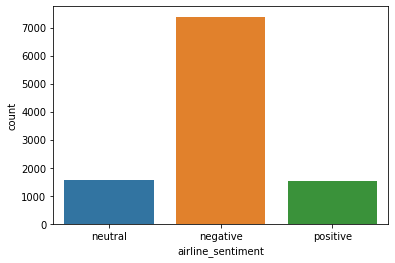

In [19]:
# Histogram of tweet classes

sns.countplot(x='airline_sentiment', data=kaggle_df);

# Model Part 1: Supervised Tf-idf Classifiers

##### To perform supervised learning, the data will be split into two groups:

1) Train - 75% of labeled Kaggle tweets

2) Test - 25% of labeled Kaggle tweets

## LinearSVC Classifier

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [21]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [22]:
X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [23]:
svm_clf = LinearSVC(random_state=1)

In [24]:
svm_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [25]:
svm_test_pred = svm_clf.predict(X_test)

In [26]:
svm_test_acc = accuracy_score(y_test, svm_test_pred)

In [27]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_test_acc)

Confusion Matrix:
[[1692  105   37]
 [  92  258   30]
 [  34   33  331]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1834
           1       0.65      0.68      0.66       380
           2       0.83      0.83      0.83       398

    accuracy                           0.87      2612
   macro avg       0.80      0.81      0.81      2612
weighted avg       0.87      0.87      0.87      2612

------------------------------------------------------------
Test Accuracy:
0.8732771822358346


## Random Forest Model Classifier

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [29]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [30]:
X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [31]:
rf_clf = RandomForestClassifier(random_state=1)

In [32]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [33]:
rf_test_pred = rf_clf.predict(X_test)

rf_test_acc = accuracy_score(y_test, rf_test_pred)

In [34]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_test_acc)

Confusion Matrix:
[[1772   51   11]
 [ 168  198   14]
 [ 115   28  255]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1834
           1       0.71      0.52      0.60       380
           2       0.91      0.64      0.75       398

    accuracy                           0.85      2612
   macro avg       0.83      0.71      0.76      2612
weighted avg       0.85      0.85      0.84      2612

------------------------------------------------------------
Test Accuracy:
0.8518376722817764


## Multinomial Naive Bayes Classifier

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [36]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [38]:
mnb_clf = MultinomialNB()

In [39]:
mnb_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
mnb_test_pred = mnb_clf.predict(X_test)
mnb_test_acc = accuracy_score(y_test, mnb_test_pred)

In [41]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_test_acc)

Confusion Matrix:
[[1718   71   45]
 [  97  249   34]
 [  34   30  334]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1834
           1       0.71      0.66      0.68       380
           2       0.81      0.84      0.82       398

    accuracy                           0.88      2612
   macro avg       0.82      0.81      0.81      2612
weighted avg       0.88      0.88      0.88      2612

------------------------------------------------------------
Test Accuracy:
0.8809341500765697


## AdaBoost Classifier

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [43]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [44]:
X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [45]:
ada_clf = AdaBoostClassifier(random_state=1)

In [46]:
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [47]:
ada_test_pred = ada_clf.predict(X_test)
ada_test_acc = accuracy_score(y_test, ada_test_pred)

In [48]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_test_acc)

Confusion Matrix:
[[1391  394   49]
 [  97  267   16]
 [  48   64  286]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1834
           1       0.37      0.70      0.48       380
           2       0.81      0.72      0.76       398

    accuracy                           0.74      2612
   macro avg       0.70      0.73      0.69      2612
weighted avg       0.81      0.74      0.77      2612

------------------------------------------------------------
Test Accuracy:
0.7442572741194488


## XGBoost Classifier

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [50]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [51]:
X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [52]:
xgb_clf = XGBClassifier(random_state=1)

In [53]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [54]:
xgb_test_pred = xgb_clf.predict(X_test)
xgb_test_acc = accuracy_score(y_test, xgb_test_pred)

In [55]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_test_acc)

Confusion Matrix:
[[1613  173   48]
 [ 126  240   14]
 [  57   51  290]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1834
           1       0.52      0.63      0.57       380
           2       0.82      0.73      0.77       398

    accuracy                           0.82      2612
   macro avg       0.75      0.75      0.74      2612
weighted avg       0.83      0.82      0.82      2612

------------------------------------------------------------
Test Accuracy:
0.8204441041347627


## Perceptron Classifier

In [56]:
y = kaggle_df.target

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [58]:
# Vectorize data using tfidf vectorizer
vectorizer = TfidfVectorizer(max_features=4000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [59]:
X_train, y_train = multi_class_SMOTE(X_train.toarray(), y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [60]:
X_train.shape

(16644, 4000)

In [61]:
# define the keras model
model = Sequential()
model.add(Dense(100, input_dim=4000, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [62]:
# compile the keras model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 16644 samples, validate on 2612 samples
Epoch 1/5
16644/16644 [==============================] - 3s 168us/step - loss: 0.6427 - accuracy: 0.8591 - val_loss: 0.3920 - val_accuracy: 0.8733
Epoch 2/5
16644/16644 [==============================] - 3s 157us/step - loss: 0.2016 - accuracy: 0.9519 - val_loss: 0.3259 - val_accuracy: 0.8821
Epoch 3/5
16644/16644 [==============================] - 3s 156us/step - loss: 0.1178 - accuracy: 0.9707 - val_loss: 0.3452 - val_accuracy: 0.8779
Epoch 4/5
16644/16644 [==============================] - 3s 152us/step - loss: 0.0802 - accuracy: 0.9806 - val_loss: 0.3699 - val_accuracy: 0.8740
Epoch 5/5
16644/16644 [==============================] - 3s 159us/step - loss: 0.0587 - accuracy: 0.9867 - val_loss: 0.4028 - val_accuracy: 0.8702


In [64]:
nn_test_pred = model.predict_classes(X_test)
nn_test_acc = accuracy_score(y_test, nn_test_pred)

In [65]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_test_acc)

Confusion Matrix:
[[1688  101   45]
 [  93  256   31]
 [  36   33  329]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1834
           1       0.66      0.67      0.66       380
           2       0.81      0.83      0.82       398

    accuracy                           0.87      2612
   macro avg       0.80      0.81      0.80      2612
weighted avg       0.87      0.87      0.87      2612

------------------------------------------------------------
Test Accuracy:
0.8702143950995406


## Model Part 1 Summary:

In [66]:
models = ['Linear SVC', 'Random Forest', 'Multinomial Naive Bayes', 
                  'AdaBoost', 'XGBoost', 'Perceptron']
tfidf_model_accs = [svm_test_acc, rf_test_acc, mnb_test_acc, ada_test_acc,
                    xgb_test_acc, nn_test_acc]

tfidf_summary = pd.DataFrame([models, tfidf_model_accs]).T

tfidf_summary.columns = ['Classifier', 'Tfidf Accuracy']

In [67]:
tfidf_summary

Classifier Tfidf Accuracy
0               Linear SVC       0.873277
1            Random Forest       0.851838
2  Multinomial Naive Bayes       0.880934
3                 AdaBoost       0.744257
4                  XGBoost       0.820444
5               Perceptron       0.870214

# Model Part 2: Supervised Doc2Vec Classifiers

## Fit Doc2Vec Model on labeled data

In [68]:
kaggle_tokens = list(kaggle_df['tokens'])

In [69]:
tagged_data = [TaggedDocument(words=tweet, tags=[str(i)])for i, tweet in enumerate(kaggle_tokens)]

In [70]:
# Instantiate Doc2Vec (Distributed Memory) model and build model vocabulary from tweet data

model = Doc2Vec(vector_size=100, dm=1, epochs=100)

model.build_vocab(tagged_data)

In [71]:
# Train the model on full text data (ok to use all unlabled and labeled data)

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [72]:
# Now, must use trained model to infer vectors for all kaggle labeled tweets

kaggle_vecs = []
for tweet in kaggle_df.tokens:
    vec = model.infer_vector(tweet)
    kaggle_vecs.append(vec)

In [73]:
kaggle_vecs = np.array(kaggle_vecs)

## LinearSVC Classifier - Supervised d2v

In [74]:
y = kaggle_df.target
X = kaggle_vecs

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [76]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [77]:
svm_sd2v = LinearSVC(random_state=1, max_iter=5000)

In [78]:
svm_sd2v.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [79]:
svm_sd2v_test_pred = svm_sd2v.predict(X_test)

In [80]:
svm_sd2v_test_acc = accuracy_score(y_test, svm_sd2v_test_pred)

In [81]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_sd2v_test_acc)

Confusion Matrix:
[[1233  344  257]
 [  92  240   48]
 [  44   40  314]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77      1834
           1       0.38      0.63      0.48       380
           2       0.51      0.79      0.62       398

    accuracy                           0.68      2612
   macro avg       0.60      0.70      0.62      2612
weighted avg       0.77      0.68      0.70      2612

------------------------------------------------------------
Test Accuracy:
0.6841500765696784


## Random Forest Model Classifier - Supervised d2v

In [82]:
y = kaggle_df.target
X = kaggle_vecs

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [84]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [85]:
rf_sd2v_clf = RandomForestClassifier(random_state=1)

In [86]:
rf_sd2v_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [87]:
rf_sd2v_test_pred = rf_sd2v_clf.predict(X_test)

rf_sd2v_test_acc = accuracy_score(y_test, rf_sd2v_test_pred)

In [88]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_sd2v_test_acc)

Confusion Matrix:
[[1749   65   20]
 [ 241  115   24]
 [ 203   28  167]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1834
           1       0.55      0.30      0.39       380
           2       0.79      0.42      0.55       398

    accuracy                           0.78      2612
   macro avg       0.71      0.56      0.60      2612
weighted avg       0.76      0.78      0.75      2612

------------------------------------------------------------
Test Accuracy:
0.7775650842266463


## Multinomial Naive Bayes Classifier - Supervised d2v

In [89]:
y = kaggle_df.target
X = kaggle_vecs

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [91]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [92]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [93]:
mnb_sd2v_clf = MultinomialNB()

In [94]:
mnb_sd2v_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [95]:
mnb_sd2v_test_pred = mnb_sd2v_clf.predict(X_test)
mnb_sd2v_test_acc = accuracy_score(y_test, mnb_sd2v_test_pred)

In [96]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_sd2v_test_acc)

Confusion Matrix:
[[1104  459  271]
 [  96  232   52]
 [  43   67  288]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72      1834
           1       0.31      0.61      0.41       380
           2       0.47      0.72      0.57       398

    accuracy                           0.62      2612
   macro avg       0.56      0.65      0.57      2612
weighted avg       0.74      0.62      0.65      2612

------------------------------------------------------------
Test Accuracy:
0.6217457886676876


## AdaBoost Classifier - Supervised d2v

In [97]:
y = kaggle_df.target
X = kaggle_vecs

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [99]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [100]:
ada_sd2v_clf = AdaBoostClassifier(random_state=1)

In [101]:
ada_sd2v_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [102]:
ada_sd2v_test_pred = ada_sd2v_clf.predict(X_test)
ada_sd2v_test_acc = accuracy_score(y_test, ada_sd2v_test_pred)

In [103]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_sd2v_test_acc)

Confusion Matrix:
[[1474  229  131]
 [ 133  182   65]
 [  91   84  223]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1834
           1       0.37      0.48      0.42       380
           2       0.53      0.56      0.55       398

    accuracy                           0.72      2612
   macro avg       0.59      0.61      0.60      2612
weighted avg       0.74      0.72      0.73      2612

------------------------------------------------------------
Test Accuracy:
0.7193721286370597


## XGBoost Classifier - Supervised d2v

In [104]:
y = kaggle_df.target
X = kaggle_vecs

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [106]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [107]:
xgb_sd2v_clf = XGBClassifier(random_state=1)

In [108]:
xgb_sd2v_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [109]:
xgb_sd2v_test_pred = xgb_sd2v_clf.predict(X_test)
xgb_sd2v_test_acc = accuracy_score(y_test, xgb_sd2v_test_pred)

In [110]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_sd2v_test_acc)

Confusion Matrix:
[[1594  167   73]
 [ 142  193   45]
 [ 102   51  245]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1834
           1       0.47      0.51      0.49       380
           2       0.67      0.62      0.64       398

    accuracy                           0.78      2612
   macro avg       0.67      0.66      0.67      2612
weighted avg       0.78      0.78      0.78      2612

------------------------------------------------------------
Test Accuracy:
0.777947932618683


## Perceptron Classifier - Supervised d2v

In [111]:
from keras.models import Model, Sequential
from keras.layers import *

In [112]:
y = kaggle_df.target
X = kaggle_vecs

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [114]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [115]:
# define the keras model
percep_sd2v = Sequential()
percep_sd2v.add(Dense(1000, input_dim=100, activation='relu'))
percep_sd2v.add(Dense(3, activation='softmax'))

In [116]:
# compile the keras model
percep_sd2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [117]:
# fit the keras model on the dataset
percep_sd2v.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test))

Train on 16644 samples, validate on 2612 samples
Epoch 1/10
16644/16644 [==============================] - 1s 33us/step - loss: 0.5823 - accuracy: 0.7835 - val_loss: 0.5513 - val_accuracy: 0.7860
Epoch 2/10
16644/16644 [==============================] - 1s 35us/step - loss: 0.3999 - accuracy: 0.8555 - val_loss: 0.5388 - val_accuracy: 0.7982
Epoch 3/10
16644/16644 [==============================] - 1s 33us/step - loss: 0.2967 - accuracy: 0.8995 - val_loss: 0.5514 - val_accuracy: 0.7986
Epoch 4/10
16644/16644 [==============================] - 1s 37us/step - loss: 0.2133 - accuracy: 0.9367 - val_loss: 0.5673 - val_accuracy: 0.8162
Epoch 5/10
16644/16644 [==============================] - 1s 37us/step - loss: 0.1588 - accuracy: 0.9567 - val_loss: 0.5886 - val_accuracy: 0.8143
Epoch 6/10
16644/16644 [==============================] - 1s 40us/step - loss: 0.1181 - accuracy: 0.9705 - val_loss: 0.6473 - val_accuracy: 0.7982
Epoch 7/10
16644/16644 [==============================] - 1s 32us/ste

In [118]:
nn_sd2v_test_pred = percep_sd2v.predict_classes(X_test)
nn_sd2v_test_acc = accuracy_score(y_test, nn_sd2v_test_pred)

In [119]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_sd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_sd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_sd2v_test_acc)

Confusion Matrix:
[[1629  123   82]
 [ 129  209   42]
 [  71   31  296]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1834
           1       0.58      0.55      0.56       380
           2       0.70      0.74      0.72       398

    accuracy                           0.82      2612
   macro avg       0.72      0.73      0.73      2612
weighted avg       0.82      0.82      0.82      2612

------------------------------------------------------------
Test Accuracy:
0.8169984686064319


## Model Part 2 Summary:

In [120]:
sd2v_model_accs = [svm_sd2v_test_acc, rf_sd2v_test_acc, mnb_sd2v_test_acc, ada_sd2v_test_acc,
                    xgb_sd2v_test_acc, nn_sd2v_test_acc]

tfidf_summary['Supervised d2v Accuracy'] = sd2v_model_accs

summary_table = tfidf_summary

display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy
0               Linear SVC       0.873277                 0.684150
1            Random Forest       0.851838                 0.777565
2  Multinomial Naive Bayes       0.880934                 0.621746
3                 AdaBoost       0.744257                 0.719372
4                  XGBoost       0.820444                 0.777948
5               Perceptron       0.870214                 0.816998

# Model Part 3: Semi-Supervised Doc2Vec Classifiers

## Fit Doc2Vec Model on labeled & unlabeled data

In [121]:
kaggle_tokens = kaggle_df['tokens']

In [122]:
twitter_tokens = twitter_df['tokens']

In [123]:
# Combine all tokenized tweets, since we want to train Doc2Vec on all available data

all_tokens = list(kaggle_tokens.append(twitter_tokens))

In [124]:
tagged_data = [TaggedDocument(words=tweet, tags=[str(i)])for i, tweet in enumerate(all_tokens)]

In [125]:
# Instantiate Doc2Vec (Distributed Memory) model and build model vocabulary from tweet data

model = Doc2Vec(vector_size=100, dm=1, epochs=100)

model.build_vocab(tagged_data)

In [126]:
# Train the model on full text data (ok to use all unlabled and labeled data)

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [127]:
# Now, must use trained model to infer vectors for all kaggle labeled tweets

kaggle_vecs = []
for tweet in kaggle_df.tokens:
    vec = model.infer_vector(tweet)
    kaggle_vecs.append(vec)

In [128]:
kaggle_vecs = np.array(kaggle_vecs)

## LinearSVC Classifier - Semi-Supervised d2v

In [129]:
y = kaggle_df.target
X = kaggle_vecs

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [131]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [132]:
svm_ssd2v = LinearSVC(random_state=1, max_iter=10000)

In [133]:
svm_ssd2v.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [134]:
svm_ssd2v_test_pred = svm_ssd2v.predict(X_test)

In [135]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

svm_ssd2v_test_acc = accuracy_score(y_test, svm_ssd2v_test_pred)

In [136]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, svm_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(svm_ssd2v_test_acc)

Confusion Matrix:
[[1432  235  167]
 [  89  243   48]
 [  33   39  326]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1834
           1       0.47      0.64      0.54       380
           2       0.60      0.82      0.69       398

    accuracy                           0.77      2612
   macro avg       0.66      0.75      0.69      2612
weighted avg       0.81      0.77      0.78      2612

------------------------------------------------------------
Test Accuracy:
0.7660796324655437


## Random Forest Model Classifier - Semi-Supervised d2v

In [137]:
y = kaggle_df.target
X = kaggle_vecs

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [139]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [140]:
rf_ssd2v_clf = RandomForestClassifier(random_state=1)

In [141]:
rf_ssd2v_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [142]:
rf_ssd2v_test_pred = rf_ssd2v_clf.predict(X_test)

rf_ssd2v_test_acc = accuracy_score(y_test, rf_ssd2v_test_pred)

In [143]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rf_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, rf_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(rf_ssd2v_test_acc)

Confusion Matrix:
[[1754   67   13]
 [ 238  125   17]
 [ 213   26  159]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1834
           1       0.57      0.33      0.42       380
           2       0.84      0.40      0.54       398

    accuracy                           0.78      2612
   macro avg       0.74      0.56      0.61      2612
weighted avg       0.77      0.78      0.75      2612

------------------------------------------------------------
Test Accuracy:
0.7802450229709035


## Multinomial Naive Bayes Classifier - Semi-Supervised d2v

In [144]:
y = kaggle_df.target
X = kaggle_vecs

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [146]:
# Scale data to pass to MNB algorithm

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [147]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [148]:
mnb_ssd2v_clf = MultinomialNB()

In [149]:
mnb_ssd2v_clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [150]:
mnb_ssd2v_test_pred = mnb_ssd2v_clf.predict(X_test)
mnb_ssd2v_test_acc = accuracy_score(y_test, mnb_ssd2v_test_pred)

In [151]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, mnb_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, mnb_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(mnb_ssd2v_test_acc)

Confusion Matrix:
[[1243  376  215]
 [  85  244   51]
 [  34   78  286]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1834
           1       0.35      0.64      0.45       380
           2       0.52      0.72      0.60       398

    accuracy                           0.68      2612
   macro avg       0.59      0.68      0.61      2612
weighted avg       0.77      0.68      0.70      2612

------------------------------------------------------------
Test Accuracy:
0.6787901990811639


## AdaBoost Classifier - Semi-Supervised d2v

In [152]:
y = kaggle_df.target
X = kaggle_vecs

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [154]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [155]:
ada_ssd2v_clf = AdaBoostClassifier(random_state=1)

In [156]:
ada_ssd2v_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [157]:
ada_ssd2v_test_pred = ada_ssd2v_clf.predict(X_test)
ada_ssd2v_test_acc = accuracy_score(y_test, ada_ssd2v_test_pred)

In [158]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, ada_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, ada_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(ada_ssd2v_test_acc)

Confusion Matrix:
[[1447  196  191]
 [ 126  186   68]
 [  80   73  245]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1834
           1       0.41      0.49      0.45       380
           2       0.49      0.62      0.54       398

    accuracy                           0.72      2612
   macro avg       0.59      0.63      0.61      2612
weighted avg       0.75      0.72      0.73      2612

------------------------------------------------------------
Test Accuracy:
0.718989280245023


## XGBoost Classifier - Semi-Supervised d2v

In [159]:
y = kaggle_df.target
X = kaggle_vecs

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [161]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [162]:
xgb_ssd2v_clf = XGBClassifier(random_state=1)

In [163]:
xgb_ssd2v_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [164]:
xgb_ssd2v_test_pred = xgb_ssd2v_clf.predict(X_test)
xgb_ssd2v_test_acc = accuracy_score(y_test, xgb_ssd2v_test_pred)

In [165]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, xgb_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, xgb_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(xgb_ssd2v_test_acc)

Confusion Matrix:
[[1605  146   83]
 [ 138  197   45]
 [ 106   45  247]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1834
           1       0.51      0.52      0.51       380
           2       0.66      0.62      0.64       398

    accuracy                           0.78      2612
   macro avg       0.68      0.67      0.67      2612
weighted avg       0.78      0.78      0.78      2612

------------------------------------------------------------
Test Accuracy:
0.7844563552833078


## Perceptron Classifier - Semi-Supervised d2v

In [166]:
y = kaggle_df.target
X = kaggle_vecs

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [168]:
X_train, y_train = multi_class_SMOTE(X_train, y_train, n=3, random_state=1)

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\imblearn\base.py:306: UserWarning:

The target type should be binary.



Label counts after SMOTE # 2:
2    5548
1    5548
0    5548
dtype: int64


In [169]:
# define the keras model
percep_ssd2v = Sequential()
percep_ssd2v.add(Dense(1000, input_dim=100, activation='relu'))
percep_ssd2v.add(Dense(100, activation='relu'))
percep_ssd2v.add(Dense(3, activation='softmax'))

In [170]:
# compile the keras model
percep_ssd2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [171]:
# fit the keras model on the dataset
percep_ssd2v.fit(X_train, y_train, epochs=5, batch_size=100, validation_data=(X_test, y_test))

Train on 16644 samples, validate on 2612 samples
Epoch 1/5
16644/16644 [==============================] - 0s 29us/step - loss: 0.4950 - accuracy: 0.8090 - val_loss: 0.4888 - val_accuracy: 0.8193
Epoch 2/5
16644/16644 [==============================] - 0s 25us/step - loss: 0.2575 - accuracy: 0.9095 - val_loss: 0.5699 - val_accuracy: 0.7944
Epoch 3/5
16644/16644 [==============================] - 0s 25us/step - loss: 0.1446 - accuracy: 0.9534 - val_loss: 0.6231 - val_accuracy: 0.8124
Epoch 4/5
16644/16644 [==============================] - 0s 25us/step - loss: 0.0925 - accuracy: 0.9698 - val_loss: 0.7122 - val_accuracy: 0.8051
Epoch 5/5
16644/16644 [==============================] - 0s 25us/step - loss: 0.0546 - accuracy: 0.9838 - val_loss: 0.8124 - val_accuracy: 0.8120


In [172]:
nn_ssd2v_test_pred = percep_ssd2v.predict_classes(X_test)
nn_ssd2v_test_acc = accuracy_score(y_test, nn_ssd2v_test_pred)

In [173]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nn_ssd2v_test_pred))
print('---'*20)
print('Classification Report:')
print(classification_report(y_test, nn_ssd2v_test_pred))
print('---'*20)
print('Test Accuracy:')
print(nn_ssd2v_test_acc)

Confusion Matrix:
[[1628  105  101]
 [ 144  194   42]
 [  73   26  299]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1834
           1       0.60      0.51      0.55       380
           2       0.68      0.75      0.71       398

    accuracy                           0.81      2612
   macro avg       0.72      0.72      0.72      2612
weighted avg       0.81      0.81      0.81      2612

------------------------------------------------------------
Test Accuracy:
0.8120214395099541


## Model Part 3 Summary:

In [174]:
ssd2v_model_accs = [svm_ssd2v_test_acc, rf_ssd2v_test_acc, mnb_ssd2v_test_acc, ada_ssd2v_test_acc,
                    xgb_ssd2v_test_acc, nn_ssd2v_test_acc]

summary_table['Semi-Supervised d2v Accuracy'] = ssd2v_model_accs


display(summary_table)

Classifier Tfidf Accuracy  Supervised d2v Accuracy  \
0               Linear SVC       0.873277                 0.684150   
1            Random Forest       0.851838                 0.777565   
2  Multinomial Naive Bayes       0.880934                 0.621746   
3                 AdaBoost       0.744257                 0.719372   
4                  XGBoost       0.820444                 0.777948   
5               Perceptron       0.870214                 0.816998   

   Semi-Supervised d2v Accuracy  
0                      0.766080  
1                      0.780245  
2                      0.678790  
3                      0.718989  
4                      0.784456  
5                      0.812021

Feeding ~5x more data to the Doc2Vec model helps the accuracy of each classifier, but none exceed accuracy of the initial tf-idf classifiers. This is probably becuase the Doc2Vec model still hasn't had enough data to train on.

# Model Part 4: GloVe Word Embedding Classifiers

## Get GloVe Embeddings for Labeled Tweets

In [175]:
# Labeled tweets vocabulary

total_vocabulary = set(word for tweet in kaggle_df.tokens for word in tweet)

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 12301 unique tokens in the dataset.


In [176]:
# See available files for GloVe

os.listdir("C:/Users/dougl/glove.twitter.27B/")

['glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt']

In [177]:
# Get GloVe embeddings for each word present in the vocabulary

glove = {}
with open(r'C:/Users/dougl/glove.twitter.27B/glove.twitter.27B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [178]:
# Check length of glove dictionary (number of words in GloVe matched by word in corpus)

print(f'{len(glove)} of {len(total_vocabulary)} tokens in dataset matched in GloVe and vectorized!')

8268 of 12301 tokens in dataset matched in GloVe and vectorized!


## W2vVectorizer class to get GloVe mean word embeddings for tweets

In [179]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        # X should be a series of lists of tokens
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [1109]:
tokenizer = Tokenizer(num_words=len(total_vocabulary))

In [1110]:
tokenizer.fit_on_texts(kaggle_df.clean_text)
sequences = tokenizer.texts_to_sequences(kaggle_df.clean_text)

In [1111]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = 40

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(kaggle_df.target))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 12303 unique tokens.
Shape of data tensor: (10445, 40)
Shape of label tensor: (10445, 3)


In [1112]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [1113]:
embedding_matrix.shape

(12304, 100)

In [1114]:
MAX_SEQUENCE_LENGTH = 40

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [1122]:
# define the keras model
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1000, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.fit(data, labels, validation_split=0.25,
          epochs=20, batch_size=128)

Train on 7833 samples, validate on 2612 samples
Epoch 1/20
7833/7833 [==============================] - 5s 599us/step - loss: 0.7030 - acc: 0.6788 - val_loss: 0.4242 - val_acc: 0.8392
Epoch 2/20
7833/7833 [==============================] - 4s 563us/step - loss: 0.4611 - acc: 0.8342 - val_loss: 0.3123 - val_acc: 0.8966
Epoch 3/20
7833/7833 [==============================] - 4s 570us/step - loss: 0.3322 - acc: 0.8771 - val_loss: 0.2923 - val_acc: 0.8993
Epoch 4/20
7833/7833 [==============================] - 4s 568us/step - loss: 0.2823 - acc: 0.8977 - val_loss: 0.2760 - val_acc: 0.9066
Epoch 5/20
7833/7833 [==============================] - 5s 589us/step - loss: 0.2432 - acc: 0.9110 - val_loss: 0.2657 - val_acc: 0.9108
Epoch 6/20
7833/7833 [==============================] - 5s 622us/step - loss: 0.1999 - acc: 0.9299 - val_loss: 0.3816 - val_acc: 0.8652
Epoch 7/20
7833/7833 [==============================] - 5s 615us/step - loss: 0.1610 - acc: 0.9429 - val_loss: 0.3128 - val_acc: 0.9001


(10445, 3)

In [ ]:
# # Loop to iteratively perform self-training iterations
# counter = 0
# pseudo_label_count = 0

# svm_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=1))])

# while len(U) > 0:
    
#     # Instantiate classifier and fit to training data

#     svm_clf.fit(X_train, y_train)
    
#     # Generate classifier predictions and confidence scores
#     U_preds = pd.Series(svm_clf.predict(U), index=U.index)
#     U_conf = svm_clf.predict_proba(U)
    
#     # Zip predictions with indices and confidence scores
#     U_preds_scores = list(zip(list(U.index), U_preds, U_conf))
    
#     # Sort predictions by confidence scores
#     U_preds_scores_sorted = sorted(U_preds_scores, key=lambda x: np.max(x[2]), reverse=True)
    
#     # Select top 100 most confident predictions
#     top_100_index = [x[0] for x in U_preds_scores_sorted[:100]]
    
#     # Update training data with top 100 X instances and predictions
#     X_train = pd.concat([X_train, U[top_100_index]], axis=0)
#     y_train = pd.concat([y_train, U_preds[top_100_index]], axis=0)
    
#     # Remove top 100 instances from unlabeled data U
#     U = U.drop(labels=top_100_index, axis=0)
    
#     # Update running count of pseudo labels created
#     pseudo_label_count += len(top_100_index)
    
#     # Generate test predictions and calculate accuracy
#     y_test_preds = svm_clf.predict(X_test)
#     y_test_acc = accuracy_score(y_test, y_test_preds)
    
#     # Print classifier results at this iteration
#     print(f'Test Accuracy at Iteration {counter}:')
#     print(y_test_acc)
#     print('-'*20)
#     print(f'Total Pseudo-Labels Added to Training Set: {pseudo_label_count}')
    
#     # Update counter with each iteration
#     counter += 1


# Model Part __: Pseudo Labeling using VADER Sentiment Analyzer

In [375]:
sia = SentimentIntensityAnalyzer()

In [376]:
kaggle_df['vader_score'] = [sia.polarity_scores(i)['compound'] for i in kaggle_df.text]

In [377]:
def vader_label(vader_score):
    'Functiont to classify instance of a vader score as positive, negative, or neutral.'
    if vader_score > 0:
        return 'positive'
    elif vader_score < 0:
        return 'negative'
    else:
        return 'neutral'

In [378]:
# Get vader labels for kaggle_df

kaggle_df['vader_label'] = kaggle_df['vader_score'].apply(vader_label)

In [379]:
# Let's check value counts for labeled airline_sentiment and vader predictions

print('Airline Sentiment Label Counts:')
print(kaggle_df.airline_sentiment.value_counts())
print('\n')
print('Vader Predicted Label Counts:')
print(kaggle_df.vader_label.value_counts())

Airline Sentiment Label Counts:
negative    7382
neutral     1548
positive    1515
Name: airline_sentiment, dtype: int64


Vader Predicted Label Counts:
negative    4281
positive    4079
neutral     2085
Name: vader_label, dtype: int64


In [380]:
# Now that we seem to have similar class balances, let's check the classification report and confusion matrix

print('Confusion Matrix:')
print(confusion_matrix(kaggle_df.airline_sentiment, kaggle_df.vader_label))
print('---'*20)
print('Classification Report:')
print(classification_report(kaggle_df.airline_sentiment, kaggle_df.vader_label))
print('---'*20)
print('Test Accuracy:')
print(accuracy_score(kaggle_df.airline_sentiment, kaggle_df.vader_label))

Confusion Matrix:
[[4039 1267 2076]
 [ 206  733  609]
 [  36   85 1394]]
------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.55      0.69      7382
     neutral       0.35      0.47      0.40      1548
    positive       0.34      0.92      0.50      1515

    accuracy                           0.59     10445
   macro avg       0.55      0.65      0.53     10445
weighted avg       0.77      0.59      0.62     10445

------------------------------------------------------------
Test Accuracy:
0.5903303015797032


Using VADER to generate 'pseudo labels' only results in about a 54% classification match when compared with the kaggle airline sentiment labels. This means that VADER is probably not a good fit to generate 'pseudo labels' for my unlabed twitter data.

In [1089]:
len(kaggle_df)

10445